<a href="https://colab.research.google.com/github/donggale72/10000.html/blob/main/ch05_13_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.13. 사이킷런 실습 - 앙상블

---
* 날짜:
* 이름:

## 학습내용
    - 모델 앙상블에 대한 개념을 이해한다.
    - 배깅(bagging) : 부트스트랩(bootstrp) 샘플링을 통한 분류 앙상블 기법을 이해한다.
    - 부스팅 기반의 에이다부스트(AdaBoost) 알고리즘을 이해한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 7장. 다양한 모델을 결합한 앙상블 학습

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

#### 데이터 가져오기

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
print(df_wine.shape)
df_wine.head()

(178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
df_wine.corr()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Class label,1.000000,-0.328222,0.437776,-0.049643,0.517859,-0.209179,-0.719163,-0.847498,0.489109,-0.499130,0.265668,-0.617369,-0.788230,-0.633717
Alcohol,-0.328222,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic acid,0.437776,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,-0.049643,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Alcalinity of ash,0.517859,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Magnesium,-0.209179,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Total phenols,-0.719163,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,-0.847498,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid phenols,0.489109,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanthocyanins,-0.499130,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417


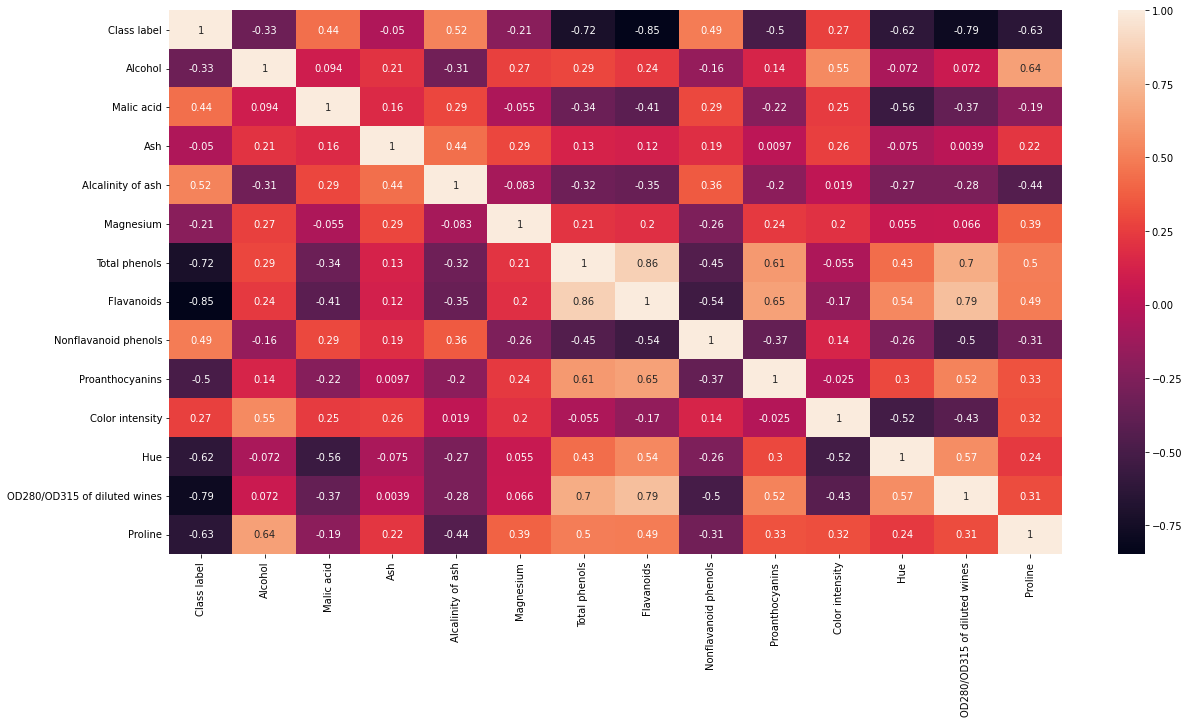

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_wine.corr(),annot=True)

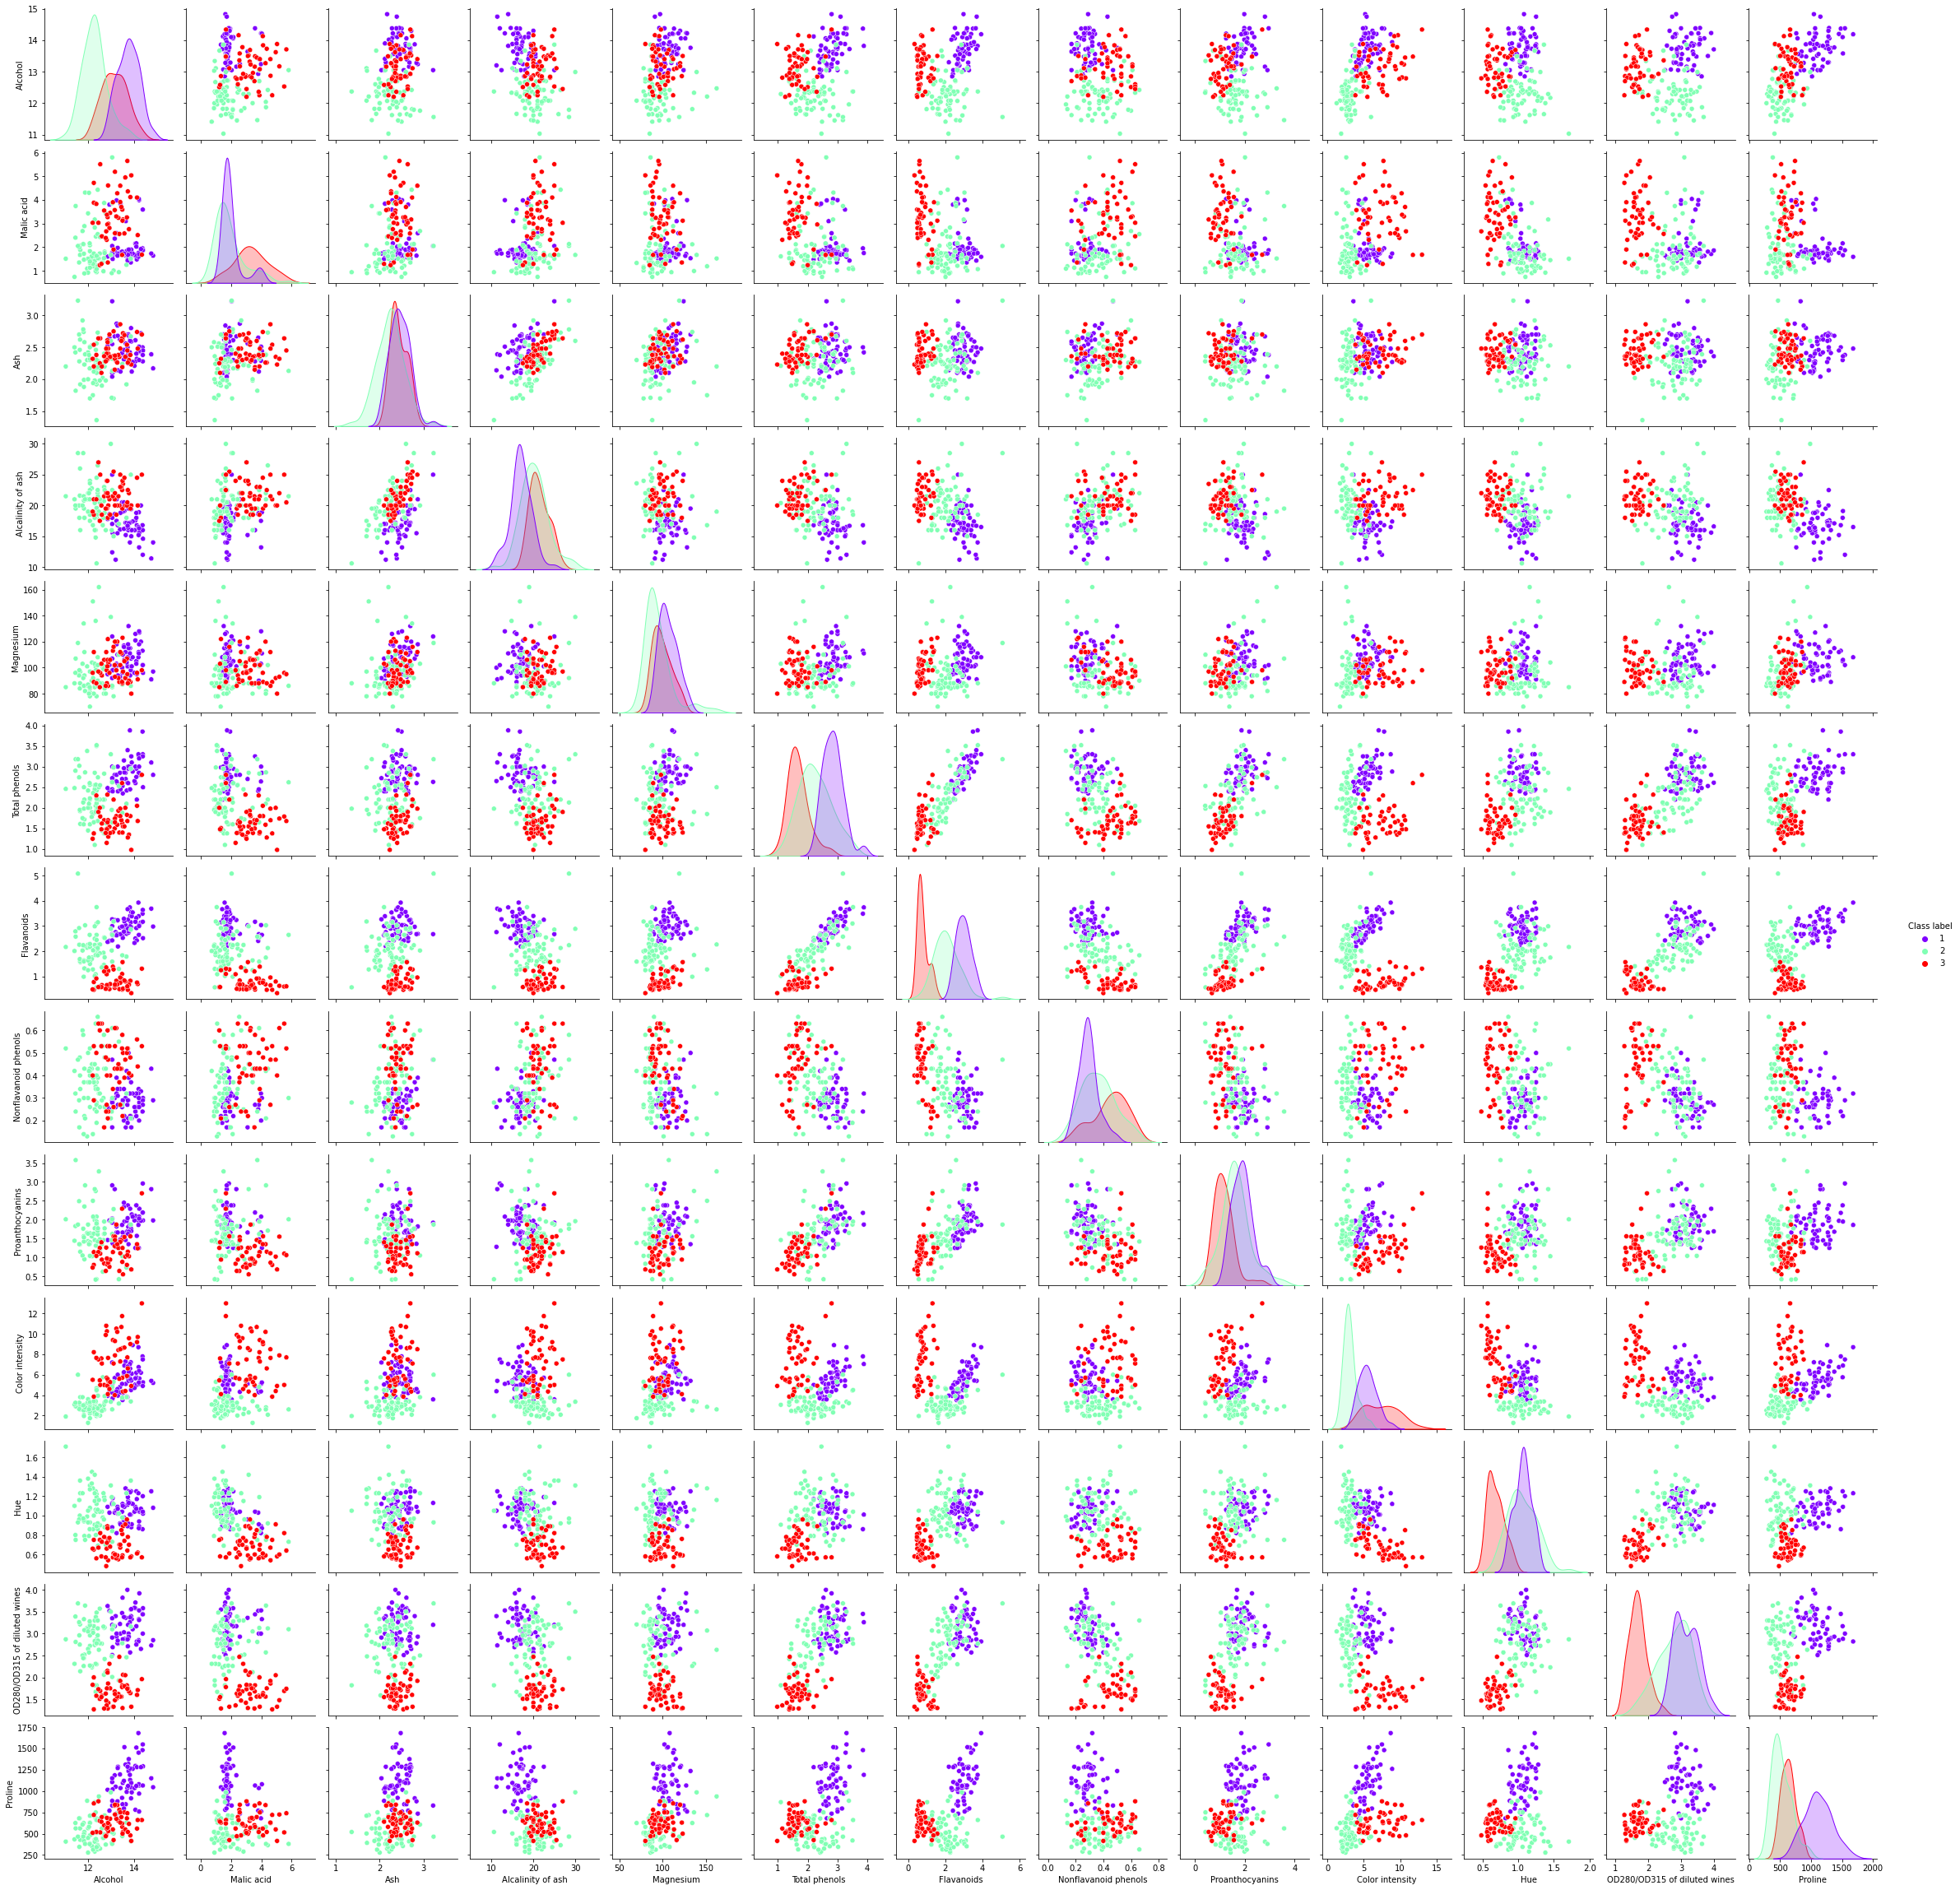

In [ ]:
sns.pairplot(df_wine,hue='Class label',palette='rainbow')

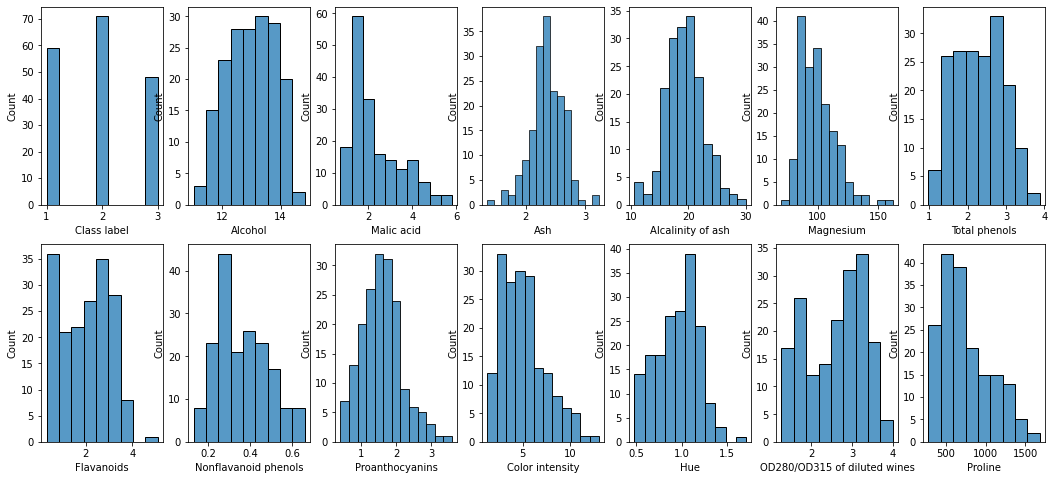

In [ ]:
fig, axes = plt.subplots(2, 7, figsize =(18,8))
axes = axes.flatten()
for i, ax in  zip(df_wine.columns, axes):
  sns.histplot(data=df_wine, x=df_wine[i], ax=ax)
plt.show()

In [ ]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class label                   178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

#### 학습을 위한 데이터 처리
* 와인 클래스 2와 클래스 3만 사용 (1은 제거)
* 두개의 특성 Alcohol과 'OD280/OD315 of diluted wines'만 사용

In [ ]:
df_wine['Class label'].unique()

array([1, 2, 3])

In [ ]:
df_wine['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [ ]:
#mask=df_wine['Class label']!=1 #1인 자료 제거
#df_wine=df_wine[mask]
#x와 y로 구분
X=df_wine[['Alcohol','Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']].values
y=df_wine['Class label'].values
X.shape, y.shape
listx = ['Alcohol','Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

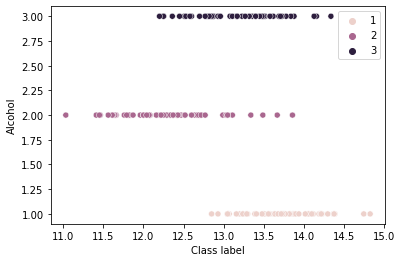

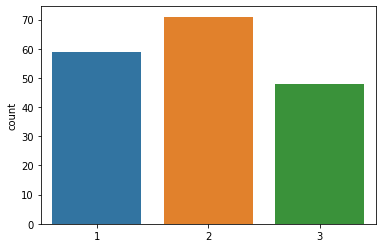

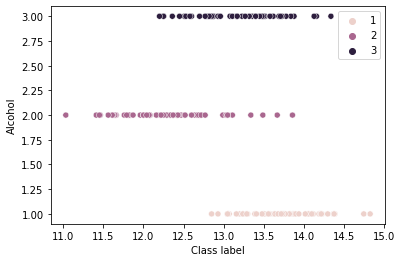

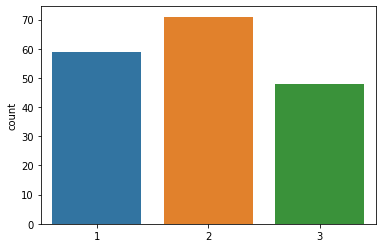

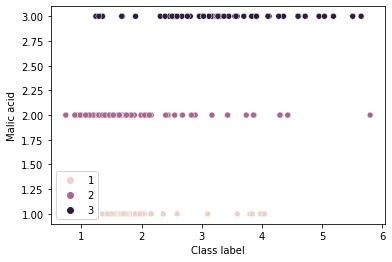

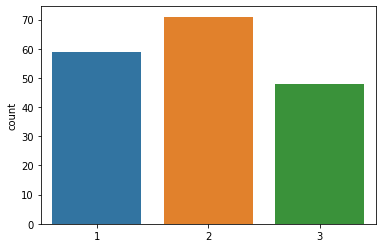

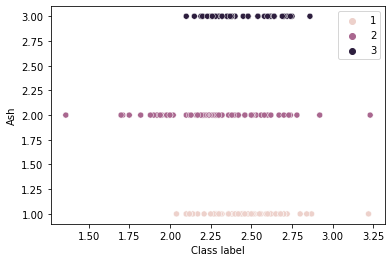

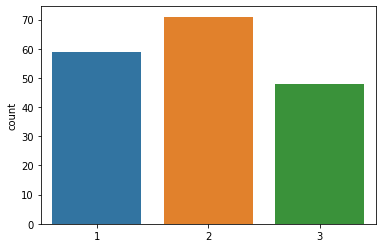

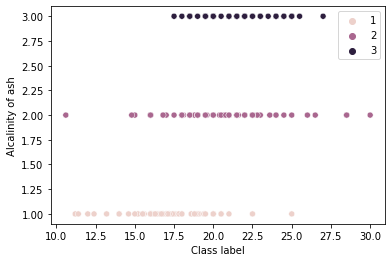

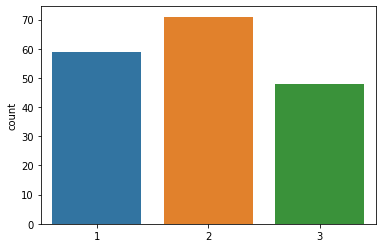

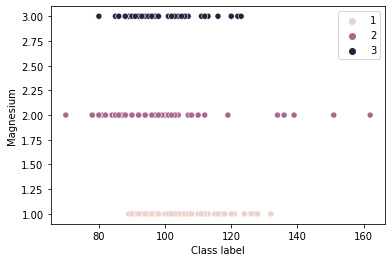

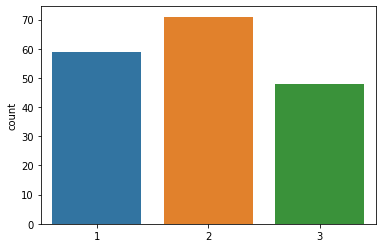

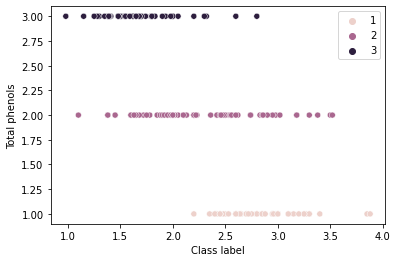

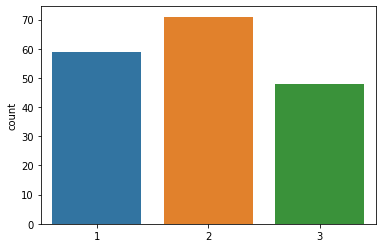

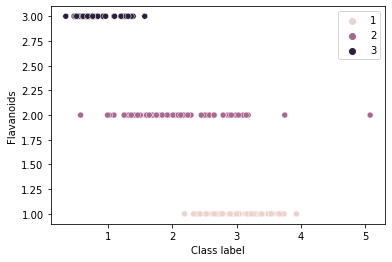

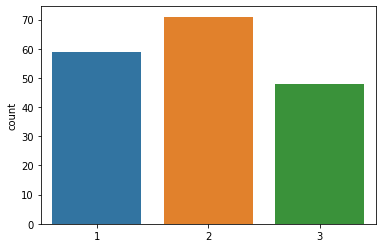

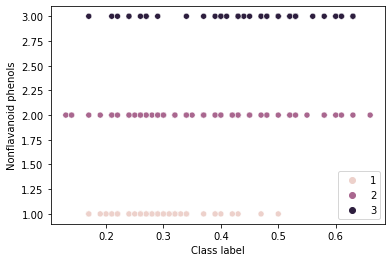

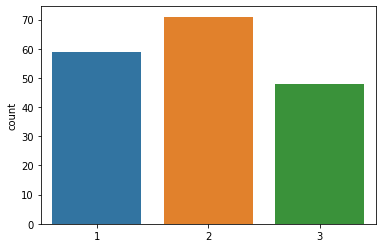

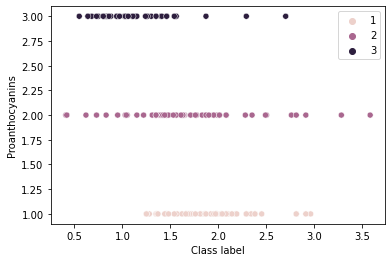

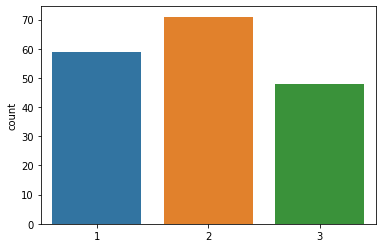

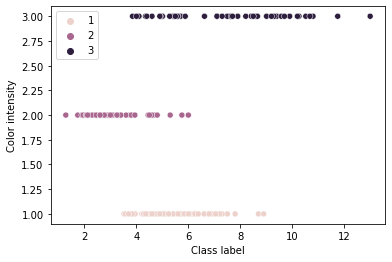

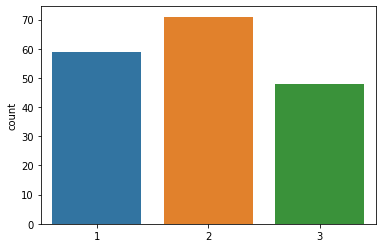

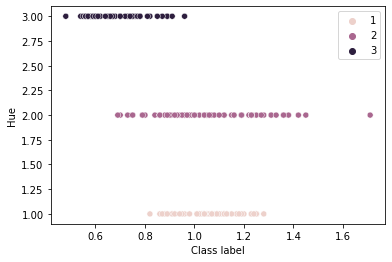

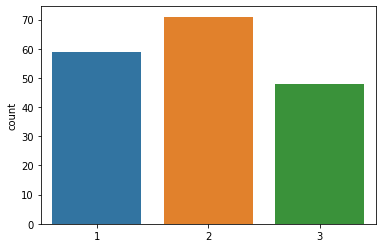

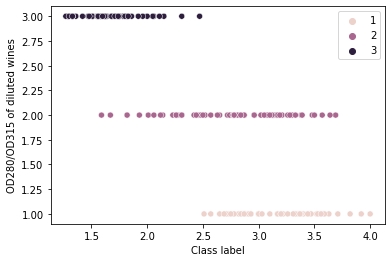

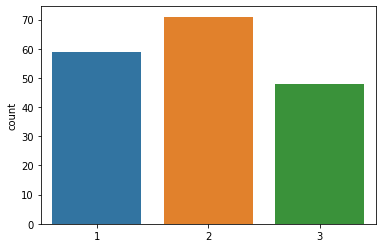

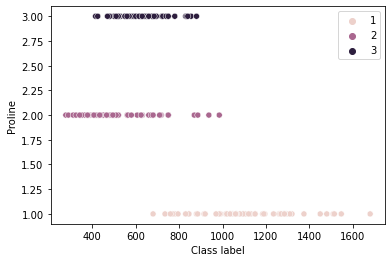

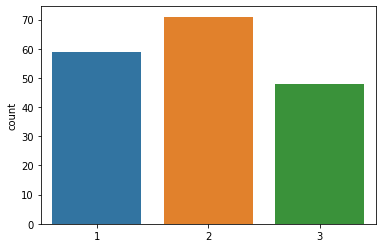

In [ ]:
 for i in listx:
  feature1=df_wine[i]
  tagat=y
  sns.scatterplot(x=feature1, y=tagat, hue=y)
  plt.xlabel('Class label')
  plt.ylabel(i)
  plt.show()
  sns.countplot(x=y)
  plt.show()

#### 전처리

In [ ]:
#라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)
#훈련-테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((142, 14), (36, 14), (142,), (36,))

#### 분포 시각화

## 다수결 투표 방식을 사용한 예측
---

<p align='center'>
<img src=https://git.io/Jtskl?raw=true width=600>
</p>



#### 모델 구성

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

lr=LogisticRegression(random_state=1, 
                      penalty='l2')
tree=DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=1)
knn=KNeighborsClassifier(n_neighbors=1,
                         p=2,
                         metric='minkowski')
voting=VotingClassifier(estimators=[('logistic',lr),
                                    ('tree', tree),
                                    ('knn', knn)],
                        voting='soft') #  (hard,soft)
models=['lr','tree','knn','voting']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score

print('10-겹 교차검증:')
for model in models:
  scores=cross_val_score(estimator=eval(model),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='accuracy')
  print(f'{model} Acc:{scores.mean():.2f} (+/- {scores.std():.2f})')

10-겹 교차검증:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


lr Acc:0.95 (+/- 0.03)
tree Acc:0.58 (+/- 0.06)
knn Acc:0.74 (+/- 0.12)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


voting Acc:0.83 (+/- 0.11)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### 스코어 계산

In [ ]:
for model in models:
  eval(model).fit(X_train, y_train)
  train_score=eval(model).score(X_train, y_train)
  test_score=eval(model).score(X_test, y_test)
  print(f'{model} train Acc:{train_score:.2f} Test Acc:{test_score: .2f}')

lr train Acc:0.96 Test Acc: 0.89
tree train Acc:0.60 Test Acc: 0.61
knn train Acc:1.00 Test Acc: 0.78
voting train Acc:1.00 Test Acc: 0.86


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### 모델 별 분류경계 시각화

ValueError: ignored

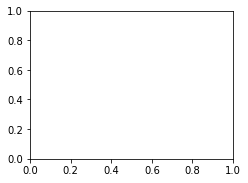

In [ ]:
plt.figure(figsize=(8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train, y_train, X_test, y_test, title=model)
plt.show()

## 배깅(Bagging: Bootrstrap aggregating)
----

<p align='center'>
<img src=https://git.io/Jtsk4?raw=true width=500>
</p>

#### 모델 구성

```
sklearn.ensemble.BaggingClassifier(
                                  base_estimator=None,#데이터 세트의 임의 하위 집합에 맞는 기본 분류기입니다. None인 경우 기본 분류기는 DecisionTreeClassifier입니다. 
                                  n_estimators=10,#앙상블의 기본 분류기 수입니다. *, 
                                  max_samples=1.0#각 기본 분류기를 학습하기 위해 X에서 그릴 샘플 수입니다, 
                                  max_features=1.0#각 기본 분류기를 학습하기 위해 X에서 그릴 피처의 수입니다, 
                                  bootstrap=True #샘플을 교체하여 그릴 지 여부. False이면 교체하지 않고 샘플링이 수행됩니다., 
                                  bootstrap_features=False#피쳐가 대체되어 그려지는지 여부, 
                                  oob_score=False #일반화 오류를 추정하기 위해 기존샘플 이외의 데이터를 사용할지 여부. 부트스트랩=True인 경우에만 사용할 수 있습니다., 
                                  warm_start=False #True로 설정하면 이전에 추정된 솔루션을 다시 사용하여 앙상블에 적합하고 더 많은 분류기를 추가하고, 그렇지 않으면 완전히 새로운 앙상블에 맞춥니다, 
                                  n_jobs=None#적합과 예측 모두에 대해 병렬로 실행할 작업의 수입니다., 
                                  random_state=None#원래 데이터 세트의 무작위 재샘플링을 제어합니다, 
                                  verbose=0 #피팅 및 예측시 자세한 정보를 제어합니다.

```

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier(criterion='entropy',
                            max_depth=None,
                            random_state=1)
bagging=BaggingClassifier(base_estimator=tree,
                          n_estimators=500, 
                          random_state=1)
models=['tree','bagging']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score

print('10-겹 교차검증:')
for model in models:
  scores=cross_val_score(estimator=eval(model),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='accuracy')
  print(f'{model} Acc:{scores.mean():.2f} (+/- {scores.std():.2f})')

#### 스코어 계산

In [ ]:
for model in models:
  eval(model).fit(X_train, y_train)
  train_score=eval(model).score(X_train, y_train)
  test_score=eval(model).score(X_test, y_test)
  print(f'{model} train Acc:{train_score:.2f} Test Acc:{test_score: .2f}')

#### 모델 별 분류경계 시각화

In [ ]:
plt.figure(figsize=(8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train, y_train, X_test, y_test, title=model)
plt.show()

##  에이다부스트(AdaBoost)
---


<p align='center'>
<img src=https://camo.githubusercontent.com/e0966809177c396bd5f64c2142e11ca7f31dfb05094ac671c5f425fbd2cd2f91/68747470733a2f2f6769742e696f2f4a74736b30?raw=true width=500>
</p>

#### 모델구성

```
class sklearn.ensemble.AdaBoostClassifier(
                          base_estimator=None, *, 
                          n_estimators=50, 
                          learning_rate=1.0, 
                          algorithm='SAMME.R', 
                          random_state=None)[source]¶

```

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree=DecisionTreeClassifier(criterion='entropy',
                            max_depth=1,
                            random_state=1)
ada=AdaBoostClassifier(base_estimator=tree,
                       n_estimators=500,
                       learning_rate=0.1,
                       random_state=1)
models=['tree', 'ada']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score

print('10-겹 교차검증:')
for model in models:
  scores=cross_val_score(estimator=eval(model),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='accuracy')
  print(f'{model} Acc:{scores.mean():.2f} (+/- {scores.std():.2f})')

#### 스코어 계산

In [ ]:
for model in models:
  eval(model).fit(X_train, y_train)
  train_score=eval(model).score(X_train, y_train)
  test_score=eval(model).score(X_test, y_test)
  print(f'{model} train Acc:{train_score:.2f} Test Acc:{test_score: .2f}')

#### 모델 별 분류경계 시각화

In [ ]:
plt.figure(figsize=(8,6))
for i, model in enumerate(models):
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train, y_train, X_test, y_test, title=model)
plt.show()

## 앙상블 모델 정리
---

In [ ]:
from sklearn.tree import*
from sklearn.ensemble import*
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

tree=DecisionTreeClassifier(criterion='entropy',
                            max_depth=None,
                            random_state=1)
rnd_tree=RandomForestClassifier(random_state=1)
bagging=BaggingClassifier(base_estimator=tree,
                          n_estimators=500, 
                          random_state=1)
ada=AdaBoostClassifier(base_estimator=tree,
                       n_estimators=500,
                       learning_rate=0.1,
                       random_state=1)
#그래디언트 부스팅 랜덤 트리 
gbrt=GradientBoostingClassifier(random_state=1)
#xg boost
xgb=XGBClassifier(random_state=1)
#light bgm
lgb=LGBMClassifier(random_state=1)
models=['tree','rnd_tree','bagging','ada','gbrt','xgb','lgb']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score

print('10-겹 교차검증:')
for model in models:
  scores=cross_val_score(estimator=eval(model),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='accuracy')
  print(f'{model} Acc:{scores.mean():.2f} (+/- {scores.std():.2f})')

#### 스코어 계산

In [ ]:
for model in models:
  eval(model).fit(X_train, y_train)
  train_score=eval(model).score(X_train, y_train)
  test_score=eval(model).score(X_test, y_test)
  print(f'{model} train Acc:{train_score:.2f} Test Acc:{test_score: .2f}')

#### 모델 별 분류경계 시각화

In [ ]:
plt.figure(figsize=(20,4))
for i, model in enumerate(models):
  plt.subplot(1,7,i+1)
  draw_decision_region(eval(model), X_train, y_train, X_test, y_test, title=model)
plt.show()

## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Bossting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터